# Pixmo Vision-Text Alignment Evaluation

This notebook evaluates the trained Vision-Text Alignment model using retrieval metrics (Recall@K) and qualitative visualization.

**Goal**: Measure how well the vision encoder and text encoder align in the shared embedding space.

In [1]:
import os
import sys
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# Add src to path
current_dir = Path.cwd()
if str(current_dir).endswith("notebooks"):
    root_dir = current_dir.parent
    os.chdir(root_dir)
    sys.path.insert(0, str(root_dir))
else:
    root_dir = current_dir

print(f"Working directory: {Path.cwd()}")

from src.config import load_config
from src.models.alignment import MultimodalAlignmentModel
from src.data.dataset_builder import build_image_datasets_from_parquet
from src.data.transforms import get_image_transforms

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Working directory: /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular


/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda


## 1. Load Configuration and Model

In [2]:
# Load config
config_path = root_dir / "configs/pixmo_alignment.yaml"
print(f"Loading config from {config_path}...")
config = load_config(str(config_path))

# Initialize Model
print("Initializing model...")
model = MultimodalAlignmentModel(config)
model.to(device)
model.eval()
print("Model initialized.")

Loading config from /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/configs/pixmo_alignment.yaml...
Initializing model...
DEBUG: Initial config num_key_value_heads: 4
DEBUG: Final config num_key_value_heads: 4


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273
Model initialized.


In [3]:
# Select checkpoints to compare
checkpoint_paths = {
    "pixmo_notebooks": root_dir / "notebooks" / "checkpoints" / "pixmo_alignment" / "checkpoint_best.pt",
    "pixmo_outputs": root_dir / "outputs" / "pixmo_alignment" / "checkpoint_best.pt",
}

# Keep only checkpoints that exist on disk
checkpoint_paths = {name: path for name, path in checkpoint_paths.items() if path.exists()}
if not checkpoint_paths:
    raise FileNotFoundError("No checkpoints found. Update checkpoint_paths with valid locations.")

print("Checkpoints to evaluate:")
for name, path in checkpoint_paths.items():
    print(f" - {name}: {path}")


Checkpoints to evaluate:
 - pixmo_notebooks: /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/notebooks/checkpoints/pixmo_alignment/checkpoint_best.pt


## 2. Load Validation Data

In [4]:
# Load Datasets
print("Loading datasets...")
image_size = config.dataset.image_size

train_transforms = get_image_transforms(image_size, is_training=True)
val_transforms = get_image_transforms(image_size, is_training=False)

datasets = build_image_datasets_from_parquet(
    cfg=config,
    train_parquet_path=config.dataset.train_parquet,
    val_parquet_path=config.dataset.val_parquet,
    test_parquet_path=config.dataset.test_parquet,
    train_transforms=train_transforms,
    val_transforms=val_transforms,
    max_text_length=config.dataset.max_text_length,
    text_dropout_prob=config.dataset.text_dropout_prob,
)

train_dataset = datasets["train"]
val_dataset = datasets["val"]

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create DataLoader
val_loader = DataLoader(
    val_dataset,
    batch_size=64, # Larger batch size for inference
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
print(f"Validation batches: {len(val_loader)}")


Loading datasets...


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 88 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_train.parquet. Downstream loaders will skip them.
  warnings.warn(
/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 16 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_val.parquet. Downstream loaders will skip them.
  warnings.warn(


Train samples: 13912
Validation samples: 2984
Validation batches: 47


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src/data/dataset_builder.py:153: UserWarning: Removed 20 invalid images from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo/pixmo_test.parquet. Downstream loaders will skip them.
  warnings.warn(


## 3. Compute Embeddings

In [5]:
print("Computing embeddings for validation set across checkpoints...")

def extract_embeddings(model, loader, device):
    all_vision_embs, all_text_embs, all_captions = [], [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting embeddings"):
            images = batch["image"].to(device)
            texts = batch["text"]

            outputs = model(images=images, texts=texts, return_embeddings=True)

            # Normalize embeddings
            v_emb = outputs.vision_emb / outputs.vision_emb.norm(dim=-1, keepdim=True)
            t_emb = outputs.text_emb / outputs.text_emb.norm(dim=-1, keepdim=True)

            all_vision_embs.append(v_emb.cpu())
            all_text_embs.append(t_emb.cpu())
            all_captions.extend(texts)

    vision_embs = torch.cat(all_vision_embs, dim=0)
    text_embs = torch.cat(all_text_embs, dim=0)
    return vision_embs, text_embs, all_captions

results = {}

for ckpt_name, ckpt_path in checkpoint_paths.items():
    print(f"\nLoading checkpoint: {ckpt_name} -> {ckpt_path}")
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    vision_embs, text_embs, captions = extract_embeddings(model, val_loader, device)
    results[ckpt_name] = {
        "vision_embs": vision_embs,
        "text_embs": text_embs,
        "captions": captions,
        "best_val_loss": checkpoint.get("best_val_loss", "N/A"),
    }
    print(f"{ckpt_name}: Vision {vision_embs.shape}, Text {text_embs.shape}")


Computing embeddings for validation set across checkpoints...

Loading checkpoint: pixmo_notebooks -> /storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/notebooks/checkpoints/pixmo_alignment/checkpoint_best.pt


Extracting embeddings:   0%|          | 0/47 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


pixmo_notebooks: Vision torch.Size([2984, 4096]), Text torch.Size([2984, 4096])


## 4. Quantitative Evaluation (Recall@K)

In [6]:
def compute_recall_metrics(query_embs, gallery_embs, ks=[1, 5, 10]):
    """
    Compute Recall@K for retrieval.
    Assumes 1-to-1 mapping where index i in query corresponds to index i in gallery.
    """
    sim_matrix = torch.matmul(query_embs, gallery_embs.T)
    num_samples = sim_matrix.shape[0]
    metrics = {}

    max_k = max(ks)
    _, topk_indices = sim_matrix.topk(max_k, dim=1)
    ground_truth = torch.arange(num_samples).unsqueeze(1).expand(-1, max_k)
    matches = (topk_indices.cpu() == ground_truth)

    for k in ks:
        hits = matches[:, :k].any(dim=1).float().sum()
        recall = (hits / num_samples).item() * 100
        metrics[f"R@{k}"] = recall

    return metrics

print("Computing retrieval metrics for each checkpoint...")
summary_rows = []
for ckpt_name, res in results.items():
    i2t = compute_recall_metrics(res["vision_embs"], res["text_embs"])
    t2i = compute_recall_metrics(res["text_embs"], res["vision_embs"])
    res["metrics"] = {"i2t": i2t, "t2i": t2i}

    row = {
        "checkpoint": ckpt_name,
        "best_val_loss": res.get("best_val_loss"),
        **{f"i2t_{k}": v for k, v in i2t.items()},
        **{f"t2i_{k}": v for k, v in t2i.items()},
    }
    summary_rows.append(row)
    print(f"{ckpt_name} -> Image-to-Text: {i2t}, Text-to-Image: {t2i}")

summary_df = pd.DataFrame(summary_rows)
summary_df


Computing retrieval metrics for each checkpoint...
pixmo_notebooks -> Image-to-Text: {'R@1': 14.309652149677277, 'R@5': 34.617963433265686, 'R@10': 46.38069570064545}, Text-to-Image: {'R@1': 15.616622567176819, 'R@5': 38.17024230957031, 'R@10': 50.2010703086853}


,checkpoint,best_val_loss,i2t_R@1,i2t_R@5,i2t_R@10,t2i_R@1,t2i_R@5,t2i_R@10
0,pixmo_notebooks,0.0,14.309652,34.617963,46.380696,15.616623,38.170242,50.20107


## 5. Qualitative Visualization

In [7]:
# Use the first checkpoint by default; set selected_ckpt to any key in results to compare others
selected_ckpt = list(results.keys())[0]
vision_embs = results[selected_ckpt]["vision_embs"]
text_embs = results[selected_ckpt]["text_embs"]
all_captions = results[selected_ckpt]["captions"]

print(f"Showing retrieval examples for checkpoint: {selected_ckpt}")

from PIL import Image

def show_retrieval_example(idx, top_k=3):
    # Image Query
    query_img_emb = vision_embs[idx]
    scores = torch.matmul(text_embs, query_img_emb)
    top_scores, top_indices = scores.topk(top_k)
    
    print(f"\n--- Example {idx} ({selected_ckpt}) ---")
    print("Query Image Caption (GT):", all_captions[idx])
    
    # Display image if path is available
    try:
        if hasattr(val_dataset, 'dataset') and hasattr(val_dataset.dataset, 'data'):
            img_path = val_dataset.dataset.data.iloc[idx]['image_path']
            if not Path(img_path).is_absolute():
                img_path = root_dir / img_path
            display(Image.open(img_path).resize((200, 200)))
    except Exception as e:
        print(f"Could not load image: {e}")

    print("Retrieved Captions:")
    for i, res_idx in enumerate(top_indices):
        res_idx = res_idx.item()
        score = top_scores[i].item()
        is_gt = (res_idx == idx)
        marker = "[GT]" if is_gt else ""
        print(f"{i+1}. [{score:.4f}] {all_captions[res_idx]} {marker}")

# Show a few random examples
indices = np.random.choice(len(all_captions), 3, replace=False)
for idx in indices:
    show_retrieval_example(idx)


Showing retrieval examples for checkpoint: pixmo_notebooks

--- Example 1805 (pixmo_notebooks) ---
Query Image Caption (GT): The image appears to be an illustration possibly from a cozy scene in a game like Animal Crossing. The scene is set at night, evident from the shadowing and absence of sunlight. In the center, a rug adorns the floor, surrounded by an array of small stars, scattered here and there, with two yellow stars and several white ones. At the bottom right, there is a bottle, and nearby, a small fire burns atop a wooden bench log. The bottom left features a tree decorated with white flowers that have yellow centers. A
Retrieved Captions:
1. [0.3067] The image features an intricately detailed interior living room with a distinct digital art piece as its focal point. The majority of the wall is adorned with a weathered, antique-like painting set on slats of wood, depicting a serene beach scene. Central to the artwork is a brown hammock tied to a tree with red blossoms, sheddi

## 6. Explainability Plots

Generating t-SNE plots per checkpoint...


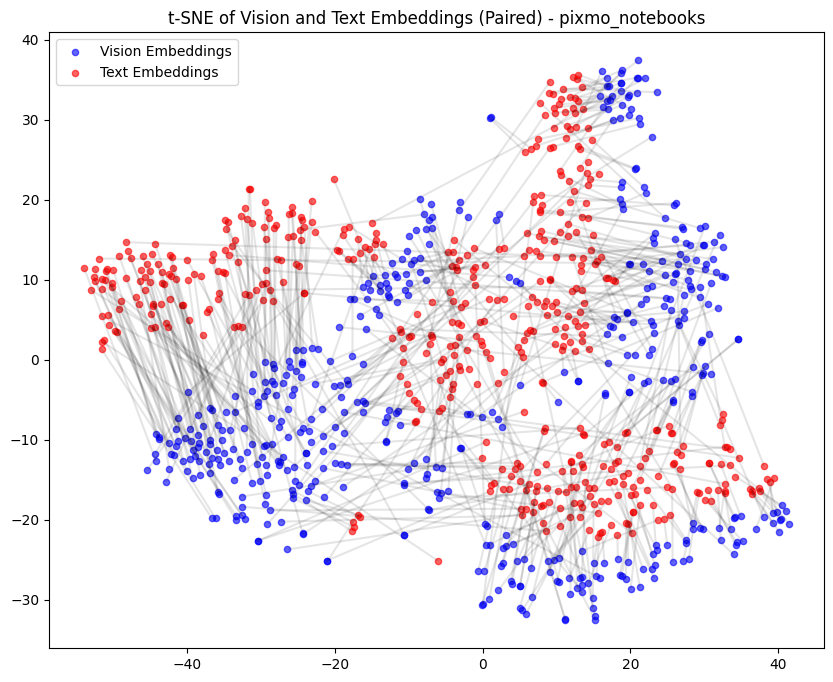

Generating Similarity Distribution for pixmo_notebooks...


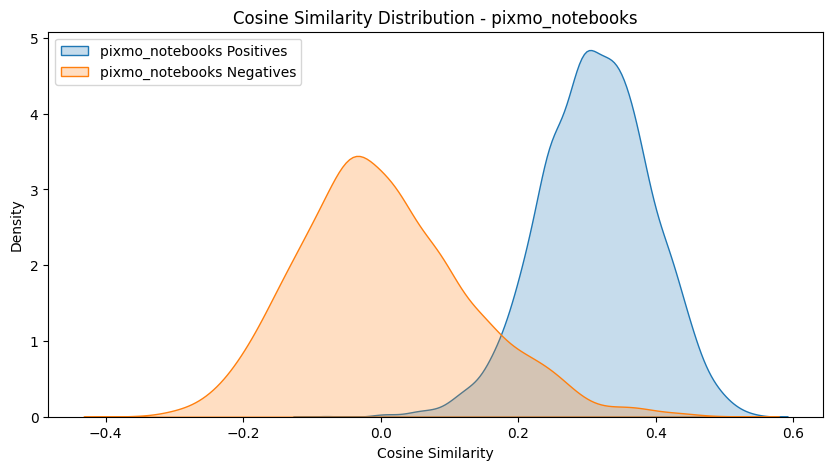

In [8]:
from sklearn.manifold import TSNE

print("Generating t-SNE plots per checkpoint...")
num_points = 500  # Subsample for speed/clarity
for ckpt_name, res in results.items():
    vision_embs = res["vision_embs"]
    text_embs = res["text_embs"]

    indices = np.random.choice(len(vision_embs), min(num_points, len(vision_embs)), replace=False)
    v_sample = vision_embs[indices].numpy()
    t_sample = text_embs[indices].numpy()

    combined_embs = np.concatenate([v_sample, t_sample], axis=0)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(combined_embs)

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:len(v_sample), 0], embeddings_2d[:len(v_sample), 1], 
                c='blue', alpha=0.6, label='Vision Embeddings', s=20)
    plt.scatter(embeddings_2d[len(v_sample):, 0], embeddings_2d[len(v_sample):, 1], 
                c='red', alpha=0.6, label='Text Embeddings', s=20)

    for i in range(len(v_sample)):
        v_pt = embeddings_2d[i]
        t_pt = embeddings_2d[len(v_sample) + i]
        plt.plot([v_pt[0], t_pt[0]], [v_pt[1], t_pt[1]], 'k-', alpha=0.1)

    plt.title(f"t-SNE of Vision and Text Embeddings (Paired) - {ckpt_name}")
    plt.legend()
    plt.show()

    # --- Similarity Distribution ---
    print(f"Generating Similarity Distribution for {ckpt_name}...")
    pos_sims = torch.sum(vision_embs * text_embs, dim=1).cpu().numpy()
    perm = torch.randperm(len(text_embs))
    neg_sims = torch.sum(vision_embs * text_embs[perm], dim=1).cpu().numpy()

    plt.figure(figsize=(10, 5))
    sns.kdeplot(pos_sims, fill=True, label=f'{ckpt_name} Positives')
    sns.kdeplot(neg_sims, fill=True, label=f'{ckpt_name} Negatives')
    plt.title(f"Cosine Similarity Distribution - {ckpt_name}")
    plt.xlabel("Cosine Similarity")
    plt.legend()
    plt.show()


Generating Similarity Heatmaps per checkpoint...


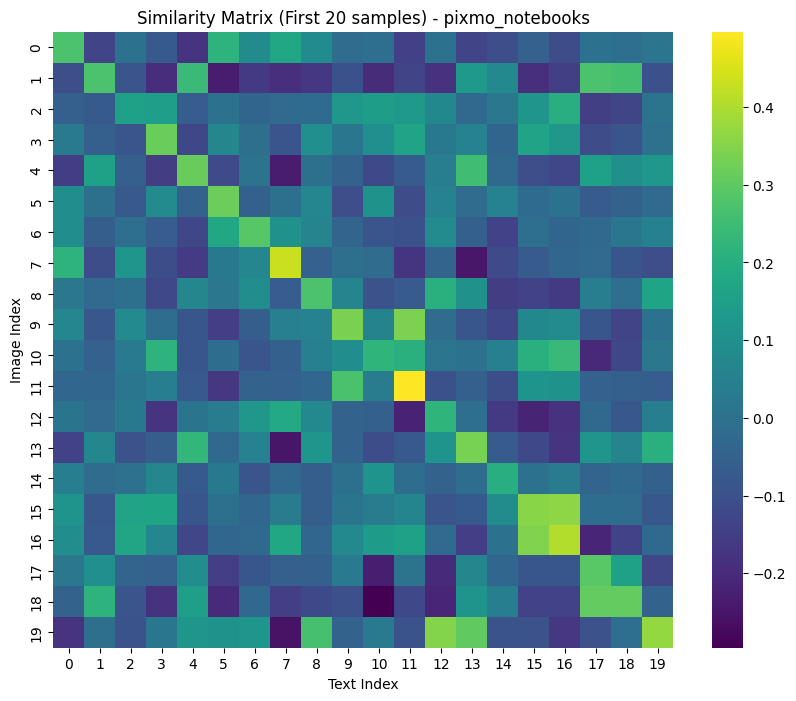

In [9]:
# --- Similarity Matrix Heatmap ---
print("Generating Similarity Heatmaps per checkpoint...")
for ckpt_name, res in results.items():
    n_ht = min(20, len(res["vision_embs"]))
    ht_indices = np.arange(n_ht)

    heatmap_v = res["vision_embs"][ht_indices]
    heatmap_t = res["text_embs"][ht_indices]

    sim_matrix_batch = torch.matmul(heatmap_v, heatmap_t.T).cpu().numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix_batch, cmap="viridis", annot=False)

    plt.xlabel("Text Index")
    plt.ylabel("Image Index")
    plt.title(f"Similarity Matrix (First {n_ht} samples) - {ckpt_name}")
    plt.show()
